# Predicción de incendios forestales

![fire_forest](https://cdn.downtoearth.org.in/library/large/2019-05-10/0.05258500_1557487635_fire2.jpg)

### Objetvo
El propósito de crear este modelo predictivo es el de prevenir posibles incendios futuros analizando las características naturales del entorno. Este tipo de modelos ayuda a entener mejor las variables que influyen en que se produzca un incendio en una zona determinada, y a que, en caso de que haya incendio, qué variables naturales influyen en que se extienda y quedem más área forestal.

### Fuente de datos
El modelo lo voy a basar en un dataset conocido del [repositorio de Machine Learning UCI](http://archive.ics.uci.edu/ml/datasets/Forest+Fires).

La información sobre las variables del dataset que proporciona el paper es la siguiente:

![variables](./img/variables.png)

Los datos fueron recogidos de Parque Natural Montesinho, al noreste de Portugal.

![mapa](./img/mapa.png)

### Pasos para crear el modelo
Para crear el modelo primero voy a explorar los datos del dataset, para después seleccionar las variables más relevantes, transformar algunas variables para dárselas al algoritmo correctamente, y finalmente entrenar el modelos y evaluar la predicción.

In [1]:
# Librerías de Python necesarias para el modelo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline

# Exploratory Data Analysis (EDA)

In [2]:
# Cargo el dataset desde la url del repositorio
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv')

In [3]:
# Visualizo el dataset para ver las columnas y el tipo de datos
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
# Amplío información con la función .info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [5]:
# Amplío información con la función .describe()
data.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Con las tres visualizaciones anteriores veo que el dataset está compuesto por 13 columnas y 517 filas (una por cada observación), que no hay valores nulos que tratar, y que todas las variables son numéricas menos "month" y "day".

Primero voy a transformar las variables "month" y "day" en numéricas sustituyendo los días de la semana en números (del 1 al 7), y agrupando los meses del año en trimestres (4 trismestres).

In [6]:
# Mapeo columnas "month" y "day"

# Divido el año en 4 intervalos de mes
dictMonth = {'jan':1, 
             'feb':1, 
             'mar':1,                                   
             'apr':2, 
             'may':2, 
             'jun':2, 
             'jul':3, 
             'aug':3,
             'sep':3, 
             'oct':4, 
             'nov':4, 
             'dec':4} 

data['month'].replace(dictMonth, inplace=True)

# Mapeo columna day
diccionarioDia = {'mon':1, 
                  'tue':2, 
                  'wed':3, 
                  'thu':4, 
                  'fri':5, 
                  'sat':6, 
                  'sun':7} 

data["day"].replace(diccionarioDia, inplace=True)

Aunque la función .describe() da mucha infromación sobre la distribución de los valores de las variables, voy a ver esa misma información de manera más visual. Primero viendo la districión de las variables, y después la correlación entre cada variables y el target (variables "area")

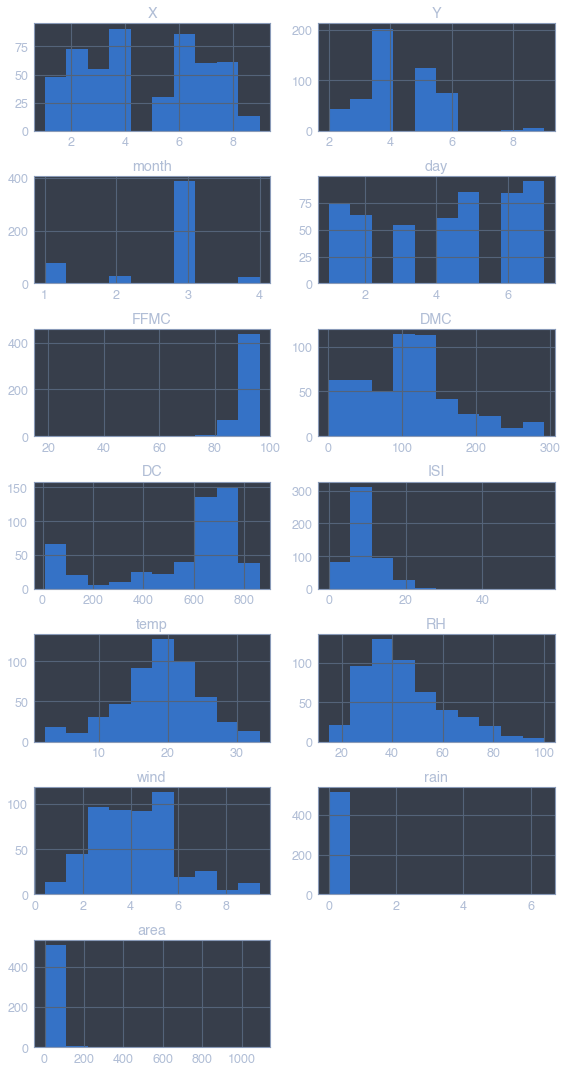

In [7]:
# Visualizo la distribución de las variables
fig, ax = plt.subplots(7,2, figsize=(8,15))
ax = ax.flatten()

for i, feature in enumerate(data.columns):
    ax[i].hist(x=data[feature])
    ax[i].set_title(feature)

ax[-1].axis('off')
fig.tight_layout()

plt.show()

En la siguiente diagrama ayuda a entender cómo están relacionadas algunas de las variables del dataset.

![diagrama](./img/diagrama.png)


Las conclusiones que puedo sacar viendo las distribuciones son las siguientes:

- "month": en el tercer trimestre (junio, julio, agosto) se concentra el mayor número de incendio. Es lógico por la estanción del año que es.
- "day": no aporta información.
- "FFMC" (humedad en la capa de la superficie del suelo): influye en que se prenda fuego. La mayoría de los valores está por encima de 90.
- "DMC" y "DC" (humedad en las capas profundas de la superficie del suelo): influye en la intensidad el fuego. La distribución no dice mucho. Tendré que ver cómo están correlacionadas.
- "ISI", "temp", "RH", "wind": siguen un distribución que se acerca a normal, con algún sesgo.
- "rain": prácticamente todos los valores están en 0.

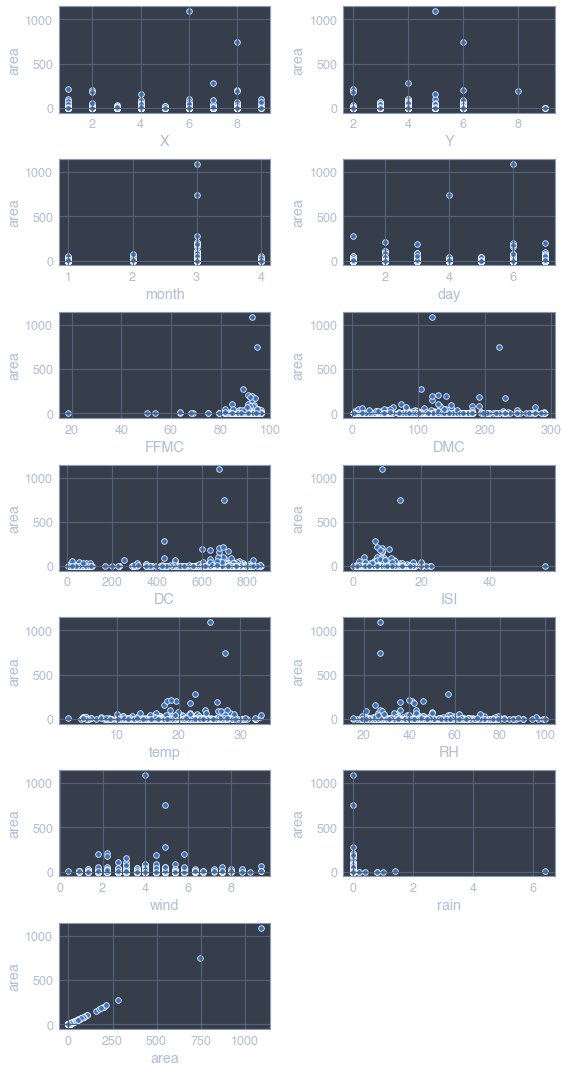

In [8]:
# Visualización de las variables con el target
fig, ax = plt.subplots(7,2, figsize=(8,15))
ax = ax.flatten()

for i, column in enumerate(data.columns):
    sns.scatterplot(data=data, x=column, y='area', ax=ax[i])
    
ax[-1].axis('off')
fig.tight_layout()

plt.show()

De la visualización de la relación entre las variables y el target saco las siguientes conlusiones:
- "ISI": cuanto menor es el valor más aumenta el área. Es lógico porque "ISI" es un valor extraído entre el "FFMC" y "wind".
- "wind": lo analizaré visualizando solo cuando ha habido incendio
- "area": se ven dos outliers cerca de 750 y por encima de 100

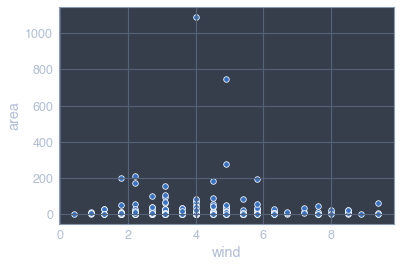

In [9]:
# Analizo "wind"

# Cojo solo los datos cuando el target es mayor que 0 (ha habido incendio)
dataFire = data[data['area'] > 0.0]

sns.scatterplot(data=dataFire, x='wind', y='area')

plt.show()

Se ve que cuando hay viendo entre los valores 2 y 6, aumenta el área quedama. Esta variable es importante.

Para terminar la exploración de los datos voy a visualizar el mapa de correlación entre las variables.

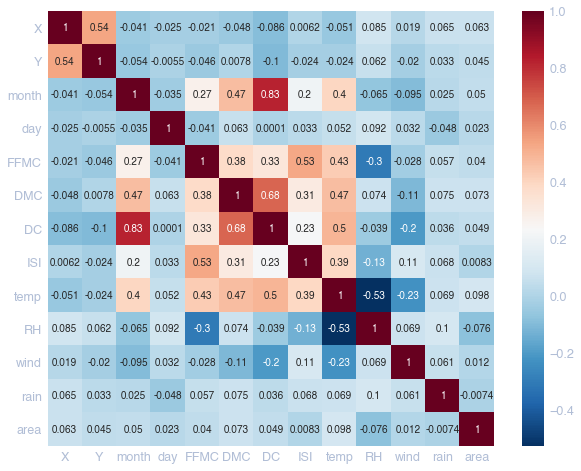

In [10]:
# Busco correlación entre columnas, y con el target
corrs = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corrs, cmap='RdBu_r', annot=True)
plt.show()

Extraigo las siguientes conluciones:
- "DC" y "DMC" correlacionadas. Ambas representan el contenido de humedad de capas orgánizas poco profundas y profundas. Elimino DC por tener menos correlación con target.
- La relación entre el target ("area") y el resto de variables sin es muy significativa, ni positiva ni negativata. Esto dificulta la predicción.

# Outliers

Antes dectecté algunos outliers en el target. Voy a analizarlos mejor y valorar eliminarlos.

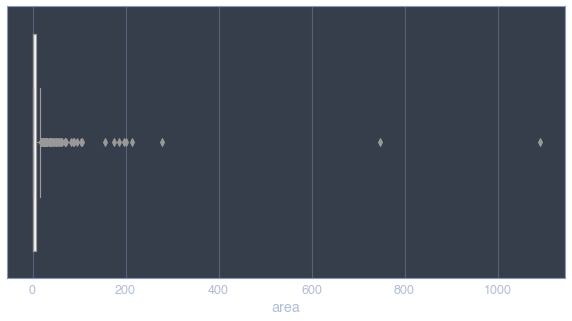

In [11]:
# Visualizo los outliers del target
plt.figure(figsize=(10,5))
sns.boxplot(x=data['area'], color='white')

plt.show()

In [12]:
# Elimino los outliers por encima de 600
data.drop(data[data['area'] > 600].index, inplace=True)

# Feature engineering

In [13]:
# Elimino "DC" por estar correlacionada con DMC y estár menos correlacionada con "area"
# Elimino "day" por no aportar información al modelo
data.drop(columns=['DC','day'], inplace=True)

In [14]:
# Convierto columnas "X" e "Y" en coordenadas vectoriales
# Columna con el módulo de la coordenada X, Y 
data["module"] = np.sqrt(data["X"]**2 + data["Y"]**2)  
# Columna con el ángulo respecto del eje X de las coordenadas X, Y
data["angle"] = np.arctan(data["Y"] / data["X"]) 
# Elimino las columnas X e Y, que ya están representadas
# por "module" y "angle"
data.drop(columns=["X", "Y"], inplace=True)

# Compruebo los cambios
data.head()

,month,FFMC,DMC,ISI,temp,RH,wind,rain,area,module,angle
0,1,86.2,26.2,5.1,8.2,51,6.7,0.0,0.0,8.602325,0.620249
1,4,90.6,35.4,6.7,18.0,33,0.9,0.0,0.0,8.062258,0.519146
2,4,90.6,43.7,6.7,14.6,33,1.3,0.0,0.0,8.062258,0.519146
3,1,91.7,33.3,9.0,8.3,97,4.0,0.2,0.0,10.000000,0.643501
4,1,89.3,51.3,9.6,11.4,99,1.8,0.0,0.0,10.000000,0.643501


## Estandarización de los datos

In [15]:
# Aplico transformación log(x+1) al target, ya que los datos son muy semejantes tal como vienen 
data['area'] = data["area"].apply(lambda x: math.log(x+1, 10))

Aplico **RobustScaler** a todas las variables menos al "area". El objetivo es reducir los efectos de los posibles outliers, además de escalar los datos de todas las variables para hacerlos más similares entre si.

In [16]:
# Estandarizo el target usando RobustScaler
# Primero separo el dataser en features X y target y
X = data.loc[:, data.columns != "area"]
# Guardo los nombres de las columnas X
XColumns = X.columns
y = data["area"].values
# Aplico RobustScaler
rb = RobustScaler() 
X = rb.fit_transform(X)

# Compruebo los cambios
XDescribe = pd.DataFrame(X, columns=XColumns).describe()
yDescribe = pd.Series(y).describe()
print('X variables', XDescribe)
print('\n y target \n', yDescribe)

X variables             month        FFMC         DMC         ISI        temp          RH  \
count  515.000000  515.000000  515.000000  515.000000  515.000000  515.000000   
mean    -0.300971   -0.358145    0.030575    0.142560   -0.060221    0.117767   
std      0.777041    2.047105    0.837436    1.061215    0.794378    0.815672   
min     -2.000000  -27.000000   -1.403141   -1.953488   -2.342466   -1.350000   
25%      0.000000   -0.518519   -0.560864   -0.453488   -0.520548   -0.450000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.481481    0.439136    0.546512    0.479452    0.550000   
max      1.000000    1.703704    2.395288   11.093023    1.917808    2.900000   

             wind        rain      module       angle  
count  515.000000  515.000000  515.000000  515.000000  
mean     0.007237    0.021748    0.028146    0.037512  
std      0.815778    0.296531    0.723742    0.833366  
min     -1.636364    0.000000   -1

# Entrenamiento, predicción y evaluación

Voy a entrenar y evaluar la predicción con los algoritmos de regressión Linear Regression y KNN. Además probaré también la predicción con el algoritmo de clasificación KNN Classifier, en el que tendré que transformar el target en binario (0, 1). En todos los casos evaluaré las predicciones con 5 K-Folds para comprobar si el modelo es robusto.

## Linear Regression + K-Fold

In [17]:
# Linear Regression + K-Fold
cv = KFold(n_splits=5, random_state=0, shuffle=True)
lr = LinearRegression()
 
for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    lr.fit(X_train, y_train)
    
    print("Precisión R2: {}".format(lr.score(X_test, y_test)))

Precisión R2: -0.03037010321501521
Precisión R2: -0.12442575175936921
Precisión R2: -0.018851298031631325
Precisión R2: -0.3710641511038679
Precisión R2: -0.04469058986176799


Debido a que los valores del target son difíciles de interpretar con una métrica de evaluación como el R2, voy a crear una score personalizado con un error con valor 0.75 de diferencia entre el valor real y el de la predicción.

## Liner Regression (Custom Score)

In [18]:
# Linear Regression (Score personalizado)
aciertos = 0 
error = 0.75
for real, predict in zip(y_test, lr.predict(X_test)): 
     if abs(real - predict) < error: 
        aciertos += 1 
print("[LR] Precisión con error {} de {}%".format(error, (aciertos/len(y_test))*100)) 
 

[LR] Precisión con error 0.75 de 90.29126213592234%


## KNN Regressor + K-Fold

In [19]:
# KNN Regressor + K-Fold
cv = KFold(n_splits=5, random_state=0, shuffle=True)
knnReg = KNeighborsRegressor(22)

for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    knnReg.fit(X_train, y_train)
    print("Precisión R2: {}".format(knnReg.score(X_test, y_test)))

Precisión R2: -0.029908812422153375
Precisión R2: -0.1539179027436135
Precisión R2: -0.16489890666589857
Precisión R2: 0.0023936819884732286
Precisión R2: 0.0028401542583925687


## KNN Regressor (Custom Score)

In [20]:
# KNN Regressor (Score personalizado)
aciertos = 0 
error = 0.75 
for real, predict in zip(y_test, knnReg.predict(X_test)): 
     if abs(real - predict) < error: 
        aciertos += 1 
print("[KNN] Precisión con error {} de {}%".format(error, (aciertos/len(y_test))*100))

[KNN] Precisión con error 0.75 de 92.23300970873787%


## KNN Classifier + K-Fold

Para crear un modelo de clasifición a parti de uno de regressión como es el caso, voy a transformar el target "area" en valores binarios (0, 1) en función de su el valor es 0.0 (no hay incencio) o es diferente a 0.0 (sí hay incencio).

In [21]:
# KNN Classifier + K-Fold
cv = KFold(n_splits=5, random_state=0, shuffle=True)
knnClf = KNeighborsClassifier(5)

for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    y_train = pd.Series(y_train)
    y_test = pd.Series(y_test)
    
    knnClf.fit(X_train, y_train.apply(lambda x: 0 if x == 0.0 else 1))
    print("Mean Accuracy: {}".format(knnClf.score(X_test, y_test.apply(lambda x: 0 if x == 0.0 else 1))))

Mean Accuracy: 0.47572815533980584
Mean Accuracy: 0.5339805825242718
Mean Accuracy: 0.5728155339805825
Mean Accuracy: 0.5533980582524272
Mean Accuracy: 0.5922330097087378


Según el score de de arriba, en este caso transformar el modelo a uno de clasifición no mejora la predicción.

## KNN Classifier + Linear Regression (Custom Score)

Finalmente quiero probar a crear una predicción encadenada entre el algoritmo KNN Classifier y Liner Regression. El algoritmo tiene en cuenta el entrenamiento que se ha hecho con estos dos modelos por separado. Va a predecir cada entrada del dataset, primero determinando si habrá indencio o no, y si lo hay predecirá qué área se quemará.

In [22]:
# Ensemble de KNN + Linear Regression

# Divido el dataset
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.2, random_state=0)
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
# KNN Classifier
knnClf = KNeighborsClassifier(5)
y_train = pd.Series(y_train)
knnClf.fit(X_train, y_train.apply(lambda x: 0 if x == 0.0 else 1))

# Primero predigo si va a haber incencio, y si lo hay, cuántas hectareas se van a quemar
prediction = list() 
for testRow in X_test: 
    testRow = testRow.reshape(1, -1) 
    if knnClf.predict(testRow) == 1: 
        prediction.append(lr.predict(testRow)) 
    else: 
        prediction.append(0.0)
        
# Score personalizado (Error y aciertos)
aciertos = 0 
error = 0.75 
for real, predict in zip(y_test, prediction): 
    if abs(real - predict) < error: 
        aciertos += 1 
print("[LR + KNN] Precisión con error {} de {}%".format(error, (aciertos/len(y_test))*100))

[LR + KNN] Precisión con error 0.75 de 72.81553398058253%


Se ve que evaluando el algoritmo encadenado con el mismo score personalizado que el usado en Linear Regression y KNN Regressor, el mejor score es el de KNN Regressor 92%, seguido de Linear Regresion 90%, y finalmente KNN + Linear Regression 72%.

# Conclusiones

La buena predicción del target es aún baja. El hecho de que las variables del dataset no estén significativamente correlacionadas con el target hace que el socore no sea tan alto.

Las variables que influyen en que haya un incendio a veces no son solo naturales, por ejemplo los incencio intencionados. Sin embargo esas variables no son medibles y no las puede tener en cuenta el modelo.

Por otro lado, la cantidad de área que se quema también depende del número de efectivos que puedan atender el incendio. Sería interesante añadir una variables que mida el número de efectivos disponibles en cada indencio registradoe en el dataset.

**Gracias por la lectura. Próximamente publicaré más modelos** 👋